In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import time

In [2]:
def load_dataset(data_dir):
    '''
    載入數據集
    data_dir是檔案名稱，是一個字串，如 r".\Data_train"
    會將圖片的參數存在X，標籤存在Y並轉呈numpy回傳
    標籤可以自行設定，如 label = {'Carambula' : 0, 'Lychee' : 1, 'Pear' : 2}
    '''
    
    class_names = os.listdir(data_dir)
    label = {'Carambula' : 0, 'Lychee' : 1, 'Pear' : 2}

    X = []
    Y = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255.0
            X.append(image)
            Y.append(label[class_name])
    
    X = np.array(X)
    Y = np.array(Y)
    onehotencoder = OneHotEncoder()
    Y = onehotencoder.fit_transform(Y.reshape(-1, 1)).toarray()
    '''
    作用是將 Y 數組變形為一個列向量。
    具體來說，-1 表示保留該維度的長度不變，
    讓 reshape 函數自動計算該維度的長度；而 1 表示將該維度的長度變為 1，也就是將一維數組變為列向量。
    '''
    
    return X, Y

In [3]:
def split_dataset(X, Y, ratio = 0.2, random_seed = 10):
    '''
    將資料集依比例(ratio)區分成訓練集跟驗證集
    ratio : 訓練集跟驗證集的比例，預設為8:2
    random_seed : 亂樹種子，預設為 10
    '''
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(len(X)) # 生成隨機序列
    val_size = int(len(X) * ratio)
    val_index = shuffled_indices[:val_size]
    train_index = shuffled_indices[val_size:]
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_val = X[val_index]
    Y_val = Y[val_index]
    return X_train, Y_train, X_val, Y_val

In [4]:
train_path = r".\Data_train"
test_path = r".\Data_test"

# 訓練集與驗證集
x_train, y_train = load_dataset(train_path)

# 測試集
x_test, y_test = load_dataset(test_path)

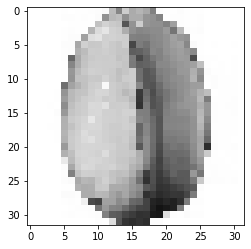

array([1., 0., 0.])

In [5]:
plt.imshow(x_train[0,:,:,:])
plt.show()
y_train[0]

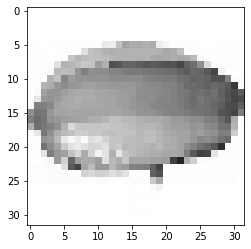

array([1., 0., 0.])

In [6]:
plt.imshow(x_test[3,:,:,:])
plt.show()
y_test[3]

In [7]:
# 正規化
def Zscore(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1e-8  # 避免除以零
    data_norm = (data - mean) / std
    return data_norm, mean, std

### Q1. PCA  

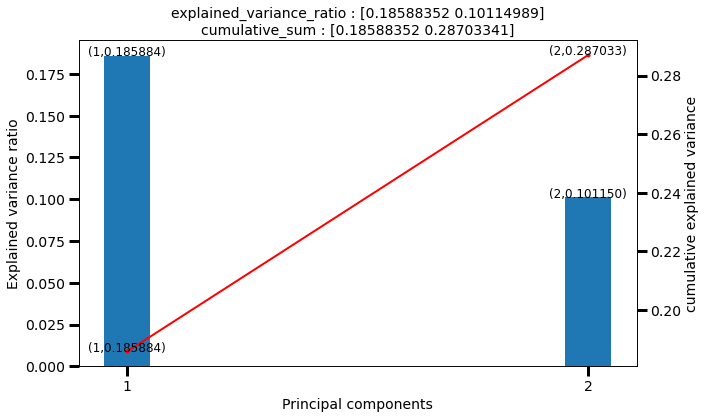

In [8]:
feature = Zscore(x_train.flatten().reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3]))[0]
pca = PCA(n_components = 2)

pca.fit(feature).transform(feature)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2], list(explained_variance_ratio), width = 0.1)
ax1.set_ylabel('Explained variance ratio',fontsize = 14)
ax1.set_xlabel('Principal components',fontsize = 14)
ax1.tick_params(axis = 'both',labelsize = 14, width = 3, length = 10)
for a, b in zip([1,2], list(explained_variance_ratio)):  
    ax1.text(a, b, f"({a},{b:.6f})", ha='center', va='baseline', fontsize=12)
    
ax2 = ax1.twinx() 
ax2.plot([1,2], list(cumulative_sum), '.-r' ,linewidth = 2, label = 'cumulative_sum')
ax2.set_ylabel('cumulative explained variance',fontsize = 14)
ax2.tick_params(axis = 'both',labelsize = 14, width = 3, length = 10)
ax1.set_title(f"explained_variance_ratio : {explained_variance_ratio}\ncumulative_sum : {cumulative_sum}",fontsize = 14)
for a, b in zip([1,2], list(cumulative_sum)):  
    ax2.text(a, b, f"({a},{b:.6f})", ha='center', va='baseline', fontsize=12)

ax1.grid(False)
ax2.grid(False)

plt.xticks([1,2])
plt.show()

Text(0, 0.5, 'principal\xa0component\xa02')

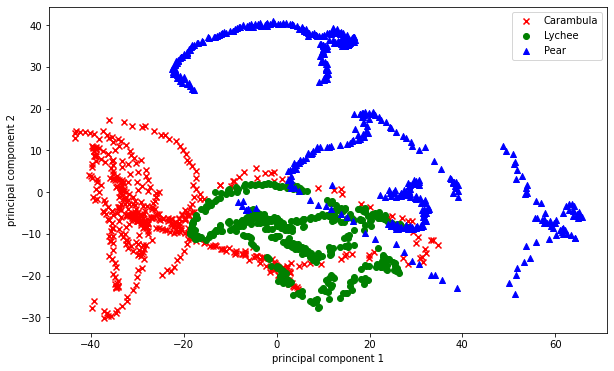

In [9]:
pc1 = pca.fit_transform(feature)

label0 = pc1[np.all(y_train == [1., 0., 0.], axis=1)]
label1 = pc1[np.all(y_train == [0., 1., 0.], axis=1)]
label2 = pc1[np.all(y_train == [0., 0., 1.], axis=1)]

plt.figure(figsize=(10,6))
plt.scatter(label0[:,0], label0[:,1], marker='x', alpha = 1, color = 'red', label = 'Carambula')
plt.scatter(label1[:,0], label1[:,1], marker='o', alpha = 1, color = 'green', label = 'Lychee')
plt.scatter(label2[:,0], label2[:,1], marker='^', alpha = 1, color = 'blue', label = 'Pear')
plt.legend(loc='best')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

In [10]:
# pc1, mean, std = Zscore(pc1)
X_train, Y_train, X_val, Y_val = split_dataset(pc1, y_train, ratio = 0.2)

### Q2. two-layer neural network

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    '''
    初始化神經網路的參數
    n_x : 輸入層的神經元數量
    n_h : 隱藏層的神經元數量
    n_h : 輸出層的神經元數量
    函數會隨機生成一些符合正態分佈的數字來初始化權重和偏差，然後將它們儲存在一個字典中。
    
    常用的權重和偏差初始化方法是使用符合正態分佈的隨機值，並將它們乘以一個較小的常數，例如 0.01。
    這樣做的目的是將初始化值控制在一個較小的範圍內，從而避免出現過大或過小的初始化值。
    同時，較小的初始化值可以加速模型的訓練，因為它們可以使梯度下降算法更容易收斂。
    '''
    np.random.seed(int(time.time()))
    W1 = np.random.randn(n_h, n_x) * 0.01  
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
def softmax(z):
    '''
    softmax的分子為 e ^ (zi)，分母為sum(e ^ (zj))
    而當z很大時，e^z會overflow；z很小時，e^z會underflow，導致電腦無法儲存
    故將z - max(z)讓取e時值域皆於0 ~ 1
    用到的觀念為softmax(z) = softmax(z + c)
    '''
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [14]:
def forward_propagation(X, parameters):
    '''
    神經網路的前向傳播過程，其作用是計算神經網路的輸出值，
    即從輸入層開始，依次經過隱藏層和輸出層，得到最終的輸出值。
    X : 輸入數據
    parameters : 神經網路的參數，包含權重與bias
    W1 : 輸入層與隱藏層之間的權重
    b1 : 輸入層與隱藏層之間的bias
    W2 : 隱藏層與輸出層之間的權重
    b2 : 隱藏層與輸出層之間的bias
    '''
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    # cache用來保存前向傳播的過程中計算出的結果 => 為了之後計算loss與反向傳播(backpropagation)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    return A2, cache

In [15]:
def compute_cost(A2, Y):
    '''
    計算神經網路的損失函數，即交叉熵損失函數(Cross-entropy)。
    A2 : 所有樣本再各個類別上的預測機率
    Y : Groundtruth(真實類別)
    '''
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(A2)) / m
    return cost

In [16]:
def backward_propagation(parameters, cache, X, Y):
    '''
    反向傳播算法，用於計算loss的梯度，以便進行參數更新
    parameters : 神經網路的參數，包含權重與bias
    cache : 保存前向傳播的過程中計算出的結果
    X : 輸入數據，維度為(n_x,m)，n_x表示為輸入層的神經元個數，m表示為樣本數量
    Y : 輸出數據，維度為(n_y,m)，n_y表示為輸出層的神經元個數，m表示為樣本數量
    '''
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y 
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    gradients = {"dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

In [17]:
def update_parameters(parameters, gradients, learning_rate):
    '''
    透過梯度下降算法更新神經網路的權重和bias。
    parameters : 神經網路的參數，包含權重與bias
    gradients : 梯度
    learning_rate : 學習率
    '''
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = gradients["dW1"]
    db1 = gradients["db1"]
    dW2 = gradients["dW2"]
    db2 = gradients["db2"]
    
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [18]:
def train_and_validate_two_layers_nn(X_train, Y_train, X_val, Y_val, n_h, epochs, learning_rate, batch_size):
    '''
    訓練神經網絡
    X_train : 訓練集的輸入
    Y_train : 訓練集的標籤
    X_val : 驗證集的輸入
    Y_val : 驗證集的標籤
    n_h：第一個隱藏層的神經元數量，整數
    epochs：神經網絡訓練的迭代次數，也就是將整個訓練集遍歷的次數。整數
    learning_rate : 學習率，浮點數，控制權重更新的速度。通常設置在 0 到 1 之間的一個小數值。
    batch_size : 每批資料量的大小
    '''
    np.random.seed(1)
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    train_accuracies = []
    train_costs = []
    val_accuracies = []
    val_costs = []
    
    for epoch in range(epochs+1):
        idx = np.random.choice(X_train.shape[1], X_train.shape[1], replace=False)
       
        for i in range(0,X_train.shape[1],batch_size):
            index = idx[i:i + batch_size]
            A2, cache = forward_propagation(X_train[:,index], parameters)
            gradients = backward_propagation(parameters, cache, X_train[:,index], Y_train[:,index])
            parameters = update_parameters(parameters, gradients, learning_rate)
        
        A2, _ = forward_propagation(X_train, parameters)   
        train_accuracy, _ = evaluate(X_train, Y_train, parameters)
        train_accuracies.append(train_accuracy)
        train_cost = compute_cost(A2, Y_train)
        train_costs.append(train_cost)

        val_accuracy, _ = evaluate(X_val, Y_val, parameters)
        val_accuracies.append(val_accuracy)
        A2, _ = forward_propagation(X_val, parameters)
        val_cost = compute_cost(A2, Y_val)
        val_costs.append(val_cost)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, train_acc: {train_accuracy:.4f}, train_loss: {train_cost:.4f}, val_acc: {val_accuracy:.4f}, val_loss: {val_cost:.4f}")
       
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Two layers NN")
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(train_costs, label='train')
    plt.plot(val_costs, label='val')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Two layers NN")
    plt.legend(loc='best')
    plt.show()
    
    return parameters, train_costs, val_accuracies

In [19]:
def evaluate(X, Y, parameters):
    '''
    X : 要預測的資料集
    Y : 預測資料集的groundtruth
    parameters : 模型權重
    '''
    A2, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis=0)
    true_labels = np.argmax(Y, axis=0)
    accuracy = np.mean(predictions == true_labels)
    return accuracy, predictions

In [20]:
# 設定參數
n_h = 256
num_epochs = 1000
learning_rate = 0.005
batch_size = 16

Epoch: 0, train_acc: 0.6803, train_loss: 0.9525, val_acc: 0.7211, val_loss: 0.9425
Epoch: 10, train_acc: 0.8265, train_loss: 0.4442, val_acc: 0.8027, val_loss: 0.4618
Epoch: 20, train_acc: 0.8444, train_loss: 0.4243, val_acc: 0.8197, val_loss: 0.4601
Epoch: 30, train_acc: 0.8478, train_loss: 0.4187, val_acc: 0.8197, val_loss: 0.4536
Epoch: 40, train_acc: 0.8469, train_loss: 0.4164, val_acc: 0.8333, val_loss: 0.4546
Epoch: 50, train_acc: 0.8529, train_loss: 0.4169, val_acc: 0.8367, val_loss: 0.4588
Epoch: 60, train_acc: 0.8503, train_loss: 0.4121, val_acc: 0.8401, val_loss: 0.4510
Epoch: 70, train_acc: 0.8469, train_loss: 0.4086, val_acc: 0.8231, val_loss: 0.4430
Epoch: 80, train_acc: 0.8401, train_loss: 0.4066, val_acc: 0.8299, val_loss: 0.4349
Epoch: 90, train_acc: 0.8401, train_loss: 0.4026, val_acc: 0.8299, val_loss: 0.4304
Epoch: 100, train_acc: 0.8503, train_loss: 0.3997, val_acc: 0.8435, val_loss: 0.4369
Epoch: 110, train_acc: 0.8546, train_loss: 0.3944, val_acc: 0.8469, val_loss

Epoch: 970, train_acc: 0.9056, train_loss: 0.2786, val_acc: 0.8946, val_loss: 0.2948
Epoch: 980, train_acc: 0.9022, train_loss: 0.2784, val_acc: 0.9082, val_loss: 0.2920
Epoch: 990, train_acc: 0.9082, train_loss: 0.2782, val_acc: 0.8878, val_loss: 0.2977
Epoch: 1000, train_acc: 0.9073, train_loss: 0.2766, val_acc: 0.8946, val_loss: 0.2922


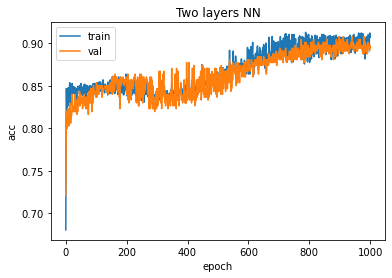

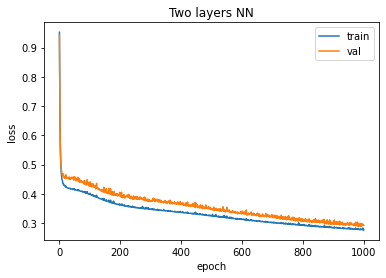

In [21]:
# 訓練與驗證
parameters, train_costs, val_accuracies = train_and_validate_two_layers_nn(X_train.T, Y_train.T, X_val.T, Y_val.T, n_h, num_epochs, learning_rate, batch_size)

In [22]:
feature_test = Zscore(x_test.flatten().reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3]))[0]
pc1_test = pca.transform(feature_test)
X_test = pc1_test
Y_test = y_test
accuracy, _ = evaluate(X_test.T, Y_test.T, parameters)
print(f"Two layers NN accuracy : {accuracy : .4f}")

Two layers NN accuracy :  0.8574


In [23]:
def plot_decision_regions(X, Y, parameters, resolution=0.1):
    # 使用顏色映射設置顏色
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    y = np.argmax(Y, axis=1)

    # 找到特徵矩陣的最小和最大值，並添加一個小的邊界
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # 生成網格點
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # 使用模型對網格點進行預測
    XX = np.array([xx1.ravel(), xx2.ravel()]).T
    num_elements = XX.shape[0]
    YY = np.tile(np.array([1., 0., 0.]), num_elements).reshape(num_elements, 3)
    _, Z = evaluate(XX.T, YY.T, parameters)
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(10,6))
    # 繪製決策區域
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 繪製散點圖
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', alpha = 1, color = 'red', label = 'Carambula')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', alpha = 1, color = 'green', label = 'Lychee')
    plt.scatter(X[y == 2, 0], X[y == 2, 1], marker='^', alpha = 1, color = 'blue', label = 'Pear')
    plt.legend(loc='best')
    plt.title("Two layers NN")
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')

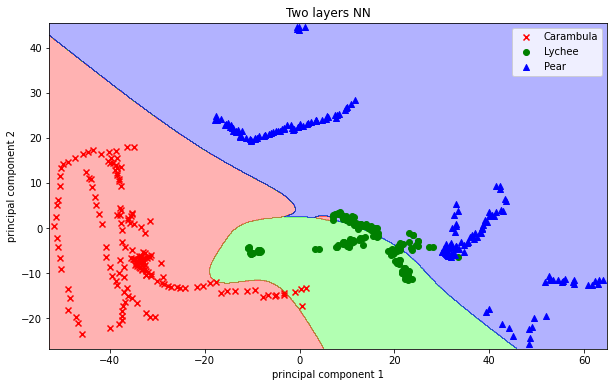

In [24]:
plot_decision_regions(X_test, Y_test, parameters)

### Q3. three-layer neural network

In [25]:
# 定義神經網絡
def initialize_parameters_3(n_x, n_h1, n_h2, n_y):
    '''
    初始化深經網路的參數
    n_x : 輸入層的神經元數量
    n_h1 : 隱藏層1的神經元數量
    n_h2 : 隱藏層2的神經元數量
    n_h : 輸出層的神經元數量
    函數會隨機生成一些符合正態分佈的數字來初始化權重和偏差，然後將它們儲存在一個字典中。
    
    常用的權重和偏差初始化方法是使用符合正態分佈的隨機值，並將它們乘以一個較小的常數，例如 0.01。
    這樣做的目的是將初始化值控制在一個較小的範圍內，從而避免出現過大或過小的初始化值。
    同時，較小的初始化值可以加速模型的訓練，因為它們可以使梯度下降算法更容易收斂。
    '''
    np.random.seed(int(time.time()))
    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

In [26]:
def forward_propagation_3(X, parameters):
    '''
    神經網路的前向傳播過程，其作用是計算神經網路的輸出值，即從輸入層開始，依次經過隱藏層和輸出層，得到最終的輸出值。
    X : 輸入數據
    parameters : 神經網路的參數，包含權重與bias
    W1 : 輸入層與隱藏層1之間的權重
    b1 : 輸入層與隱藏層1之間的bias
    W2 : 隱藏層1與隱藏層2之間的權重
    b2 : 隱藏層1與隱藏層2之間的bias
    W3 : 隱藏層2與輸出層之間的權重
    b3 : 隱藏層2與輸出層之間的bias
    '''
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    
    # cache用來保存前向傳播的過程中計算出的結果 => 為了之後計算loss與反向傳播(backpropagation)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    
    return A3, cache

In [27]:
def compute_cost_3(A3, Y):
    '''
    計算神經網路的損失函數，即交叉熵損失函數(Cross-entropy)。
    A3 : 所有樣本再各個類別上的預測機率
    Y : Groundtruth(真實類別)
    '''
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(A3)) / m
    return cost

In [28]:
def backward_propagation_3(parameters, cache, X, Y):
    '''
    反向傳播算法，用於計算loss的梯度，以便進行參數更新
    parameters : 神經網路的參數，包含權重與bias
    cache : 保存前向傳播的過程中計算出的結果
    X : 輸入數據，維度為(n_x,m)，n_x表示為輸入層的神經元個數，m表示為樣本數量
    Y : 輸出數據，維度為(n_y,m)，n_y表示為輸出層的神經元個數，m表示為樣本數量
    '''
    m = X.shape[1]
    W3 = parameters["W3"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    
    dZ3 = A3 - Y 
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m
    dZ2 = np.dot(W3.T, dZ3) * A2 * (1 - A2)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

In [29]:
def update_parameters_3(parameters, gradients, learning_rate):
    '''
    透過梯度下降算法更新神經網路的權重和bias。
    parameters : 神經網路的參數，包含權重與bias\
    gradients : 梯度
    learning_rate : 學習率
    '''
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    dW1 = gradients["dW1"]
    db1 = gradients["db1"]
    dW2 = gradients["dW2"]
    db2 = gradients["db2"]
    dW3 = gradients["dW3"]
    db3 = gradients["db3"]
    
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    return parameters

In [30]:
def train_and_validate_three_layers_nn(X_train, Y_train, X_val, Y_val, n_h1, n_h2, epochs, learning_rate, batch_size):
    '''
    訓練神經網絡
    X_train : 訓練集的輸入
    Y_train : 訓練集的標籤
    X_val : 驗證集的輸入
    Y_val : 驗證集的標籤
    n_h1：第一個隱藏層的神經元數量，整數
    n_h2：第一個隱藏層的神經元數量，整數
    epochs：神經網絡訓練的迭代次數，也就是將整個訓練集遍歷的次數。整數
    learning_rate : 學習率，浮點數，控制權重更新的速度。通常設置在 0 到 1 之間的一個小數值。
    batch_size : 每批資料量的大小
    '''
    np.random.seed(1)
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    parameters = initialize_parameters_3(n_x, n_h1, n_h2, n_y)
    
    train_accuracies = []
    train_costs = []
    val_accuracies = []
    val_costs = []
    
    for epoch in range(epochs+1):
        idx = np.random.choice(X_train.shape[1], X_train.shape[1], replace=False)
       
        for i in range(0,X_train.shape[1],batch_size):
            index = idx[i:i + batch_size]
            A3, cache = forward_propagation_3(X_train[:,index], parameters)
            gradients = backward_propagation_3(parameters, cache, X_train[:,index], Y_train[:,index])
            parameters = update_parameters_3(parameters, gradients, learning_rate)
        
        A3, _ = forward_propagation_3(X_train, parameters)
        train_accuracy, _ = evaluate_3(X_train, Y_train, parameters)
        train_accuracies.append(train_accuracy)
        train_cost = compute_cost_3(A3, Y_train)
        train_costs.append(train_cost)

        val_accuracy, _ = evaluate_3(X_val, Y_val, parameters)
        val_accuracies.append(val_accuracy)
        A3,_ = forward_propagation_3(X_val, parameters)
        val_cost = compute_cost_3(A3, Y_val)
        val_costs.append(val_cost)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, train_acc: {train_accuracy:.4f}, train_loss: {train_cost:.4f}, val_acc: {val_accuracy:.4f}, val_loss: {val_cost:.4f}")
            
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Three layers NN")
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(train_costs, label='train')
    plt.plot(val_costs, label='val')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Three layers NN")
    plt.legend(loc='best')
    plt.show()
    
    return parameters, train_costs, val_accuracies

In [31]:
def evaluate_3(X, Y, parameters):
    '''
    X : 要預測的資料集
    Y : 預測資料集的groundtruth
    parameters : 模型權重
    '''
    A3, _ = forward_propagation_3(X, parameters)
    predictions = np.argmax(A3, axis=0)
    true_labels = np.argmax(Y, axis=0)
    accuracy = np.mean(predictions == true_labels)
    return accuracy, predictions

In [32]:
# 設定參數
n_h1 = 256
n_h2 = 512
num_epochs = 1000
learning_rate = 0.01
batch_size = 16

Epoch: 0, train_acc: 0.3231, train_loss: 1.1460, val_acc: 0.3741, val_loss: 1.1190
Epoch: 10, train_acc: 0.5459, train_loss: 0.9798, val_acc: 0.5952, val_loss: 0.9510
Epoch: 20, train_acc: 0.8265, train_loss: 0.5443, val_acc: 0.8163, val_loss: 0.5567
Epoch: 30, train_acc: 0.8061, train_loss: 0.5282, val_acc: 0.8061, val_loss: 0.5608
Epoch: 40, train_acc: 0.8350, train_loss: 0.4585, val_acc: 0.8129, val_loss: 0.4817
Epoch: 50, train_acc: 0.8418, train_loss: 0.4299, val_acc: 0.8231, val_loss: 0.4593
Epoch: 60, train_acc: 0.8248, train_loss: 0.4246, val_acc: 0.8129, val_loss: 0.4507
Epoch: 70, train_acc: 0.8512, train_loss: 0.4249, val_acc: 0.8367, val_loss: 0.4673
Epoch: 80, train_acc: 0.8512, train_loss: 0.4215, val_acc: 0.8401, val_loss: 0.4627
Epoch: 90, train_acc: 0.8384, train_loss: 0.4164, val_acc: 0.8333, val_loss: 0.4479
Epoch: 100, train_acc: 0.8486, train_loss: 0.4093, val_acc: 0.8435, val_loss: 0.4421
Epoch: 110, train_acc: 0.8537, train_loss: 0.4354, val_acc: 0.8605, val_loss

Epoch: 970, train_acc: 0.9022, train_loss: 0.2360, val_acc: 0.8980, val_loss: 0.2379
Epoch: 980, train_acc: 0.9150, train_loss: 0.2373, val_acc: 0.8878, val_loss: 0.2638
Epoch: 990, train_acc: 0.9090, train_loss: 0.2341, val_acc: 0.9014, val_loss: 0.2478
Epoch: 1000, train_acc: 0.9082, train_loss: 0.2307, val_acc: 0.8912, val_loss: 0.2429


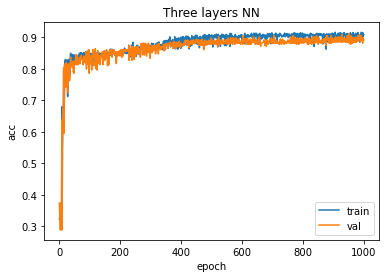

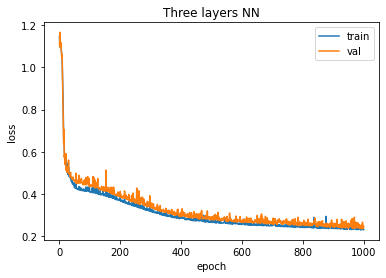

In [33]:
# 訓練與驗證
parameters, train_costs, val_accuracies = train_and_validate_three_layers_nn(X_train.T, Y_train.T, X_val.T, Y_val.T, n_h1, n_h2, num_epochs, learning_rate, batch_size)

In [34]:
feature_test = Zscore(x_test.flatten().reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3]))[0]
pc1_test = pca.transform(feature_test)
X_test = pc1_test
Y_test = y_test
accuracy, _ = evaluate_3(X_test.T, Y_test.T, parameters)
print(f"Three layers NN accuracy : {accuracy : .4f}")

Three layers NN accuracy :  0.8614


In [35]:
def plot_decision_regions_3(X, Y, parameters, resolution=0.2):
    # 使用顏色映射設置顏色
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    y = np.argmax(Y, axis=1)

    # 找到特徵矩陣的最小和最大值，並添加一個小的邊界
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # 生成網格點
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # 使用模型對網格點進行預測
    XX = np.array([xx1.ravel(), xx2.ravel()]).T
    num_elements = XX.shape[0]
    YY = np.tile(np.array([1., 0., 0.]), num_elements).reshape(num_elements, 3)
    _, Z = evaluate_3(XX.T, YY.T, parameters)
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(10,6))
    # 繪製決策區域
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 繪製散點圖
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', alpha = 1, color = 'red', label = 'Carambula')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', alpha = 1, color = 'green', label = 'Lychee')
    plt.scatter(X[y == 2, 0], X[y == 2, 1], marker='^', alpha = 1, color = 'blue', label = 'Pear')
    plt.legend(loc='best')
    plt.title("Three layers NN")
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')

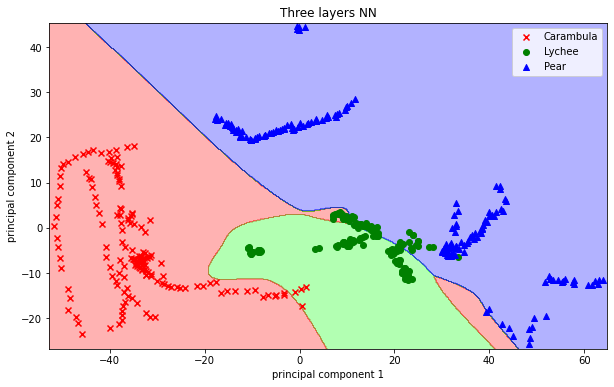

In [36]:
plot_decision_regions_3(X_test, Y_test, parameters)